In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25,15

from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
from tensorflow import GPUOptions, Session, ConfigProto

# confirm Keras sees the GPU
from keras import backend as K
assert len(K.tensorflow_backend._get_available_gpus()) > 0

gpu_options = GPUOptions(per_process_gpu_memory_fraction = 0.7)       #Assign portion of memory for training this model
sess = Session(config = ConfigProto(gpu_options = gpu_options))

Using TensorFlow backend.


In [2]:
df = pd.read_csv('FinalCovid19.csv')
df.head()

,Dates,totalconfirmed,totaldeceased,totalrecovered,Active
0,30-1-2020,1,0,0,1
1,31-1-2020,1,0,0,1
2,01-2-2020,1,0,0,1
3,02-2-2020,2,0,0,2
4,03-2-2020,3,0,0,3


In [3]:
data = df.drop(['Active','totaldeceased','totalrecovered'], axis = 1)

In [4]:
data['Dates'] = pd.to_datetime(data['Dates'], format = '%d-%m-%Y')
data.index = data['Dates']

In [5]:
data.drop(['Dates'], axis = 1, inplace = True)
data.head()

,totalconfirmed
Dates,
2020-01-30,1
2020-01-31,1
2020-02-01,1
2020-02-02,2
2020-02-03,3


In [6]:
dataset = data.values
dataset.shape

(99, 1)

In [7]:
train = dataset[:80]
valid = dataset[80:]

days = 10

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

dataset = scaler.fit_transform(dataset)

In [9]:
X_train, y_train = [],[]
for i in range(days,len(train)):
    X_train.append(dataset[i-days:i])
    y_train.append(dataset[i])
X_train, y_train = np.array(X_train),np.array(y_train)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD, RMSprop, Adam, Adagrad

In [11]:
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dropout(0.25))
model.add(Dense(1))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ProgbarLogger 


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


early_stopping = EarlyStopping(
    monitor='loss', patience=100, verbose=1, mode='auto')


history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='weights.hdf5', verbose=2, save_best_only=True)

In [13]:
optimizer = Adam(lr=0.5)

def rmse(y_pred, y_true):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer = 'adam', loss = 'mse', metrics = [rmse])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            30200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist = model.fit(X_train, y_train, epochs = 100, callbacks=[history, checkpointer], verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


70/70 [==============================] - 2s 32ms/step - loss: 0.0060 - rmse: 0.0752
Epoch 2/100
64/70 [==========================>...] - ETA: 0s - loss: 0.0046 - rmse: 0.0678

c:\users\shrey\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


70/70 [==============================] - 0s 4ms/step - loss: 0.0046 - rmse: 0.0672
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0043 - rmse: 0.0650
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0033 - rmse: 0.0571
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0026 - rmse: 0.0506
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 8.4278e-04 - rmse: 0.0283
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 2.7082e-04 - rmse: 0.0158
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 8.9705e-04 - rmse: 0.0295
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 4.6616e-04 - rmse: 0.0203
Epoch 11/100
70/70 [==============================] - 0s 2ms/step - loss: 2.5004e-04 - rmse: 0.0158
Epoch 12/100
70/70 [====================

70/70 [==============================] - 0s 2ms/step - loss: 1.2823e-04 - rmse: 0.0112
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 9.8942e-05 - rmse: 0.0097
Epoch 85/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0091e-04 - rmse: 0.0100
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 1.7009e-04 - rmse: 0.0128
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 2.1743e-04 - rmse: 0.0147
Epoch 88/100
70/70 [==============================] - 0s 2ms/step - loss: 1.5086e-04 - rmse: 0.0120
Epoch 89/100
70/70 [==============================] - 0s 2ms/step - loss: 9.0795e-05 - rmse: 0.0092
Epoch 90/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2897e-04 - rmse: 0.0112
Epoch 91/100
70/70 [==============================] - 0s 2ms/step - loss: 1.4118e-04 - rmse: 0.0113
Epoch 92/100
70/70 [==============================] - 0s 2ms/step - loss: 1.3270e-04 - rmse: 0.0114
Epoch 93/100


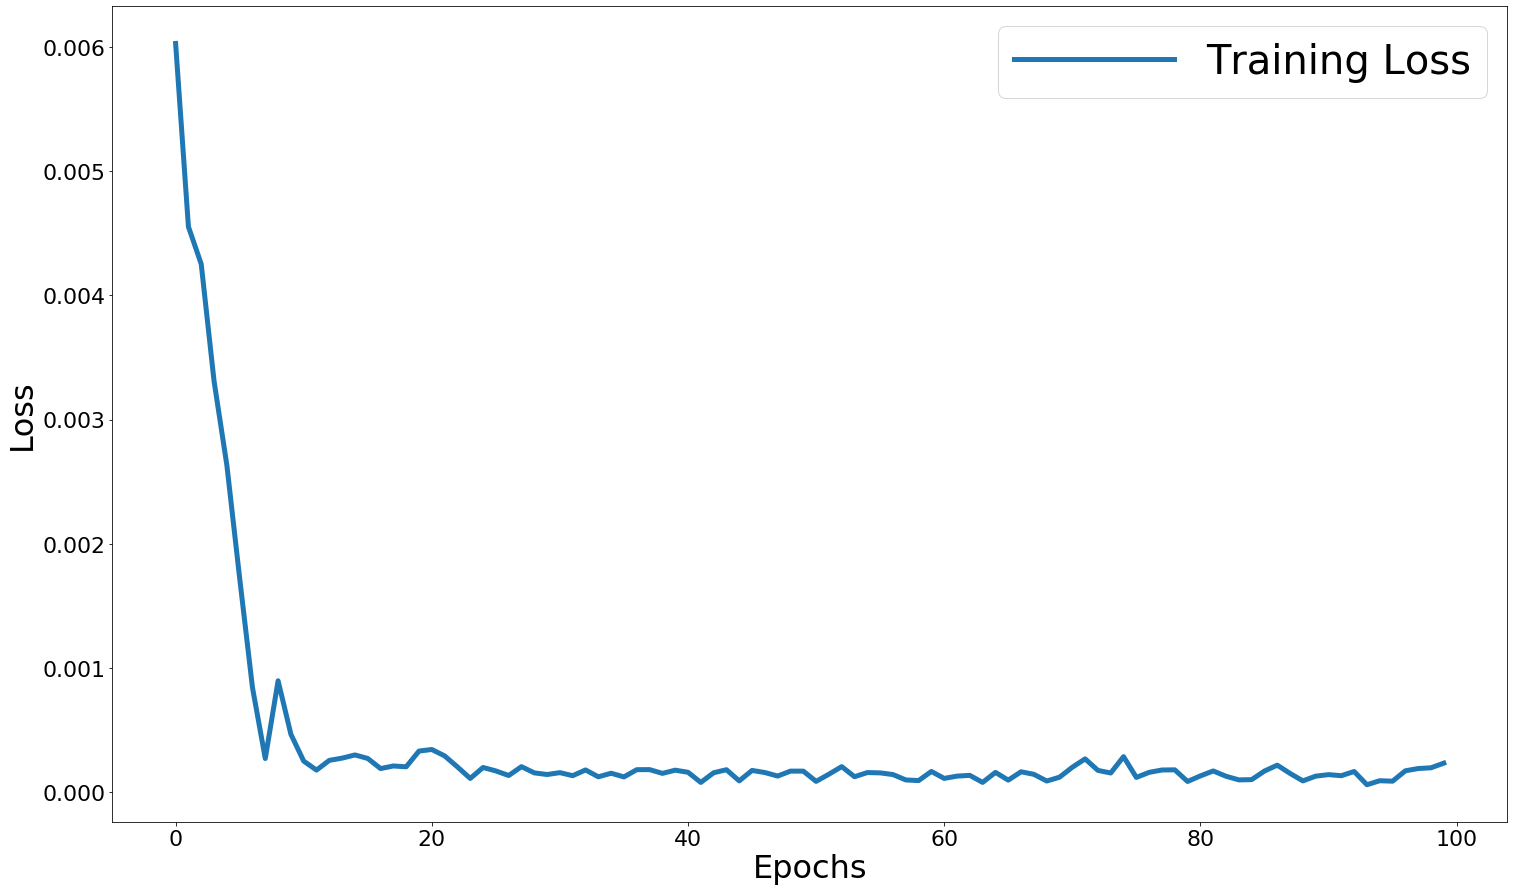

In [16]:
params = {'legend.fontsize': 40,
          'legend.handlelength': 4}
rcParams.update(params)
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels

plt.figure()
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss', linewidth = 5)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('loss.png')
plt.legend()

In [17]:
inputs = dataset[len(dataset)-len(valid)-days:]
inputs.shape

(29, 1)

In [18]:
x_test, y_test = [],[]
for i in range(days,len(inputs)):
    x_test.append(inputs[i-days:i])
    y_test.append(inputs[i])
x_test, y_test = np.array(x_test), np.array(y_test)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

c:\users\shrey\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


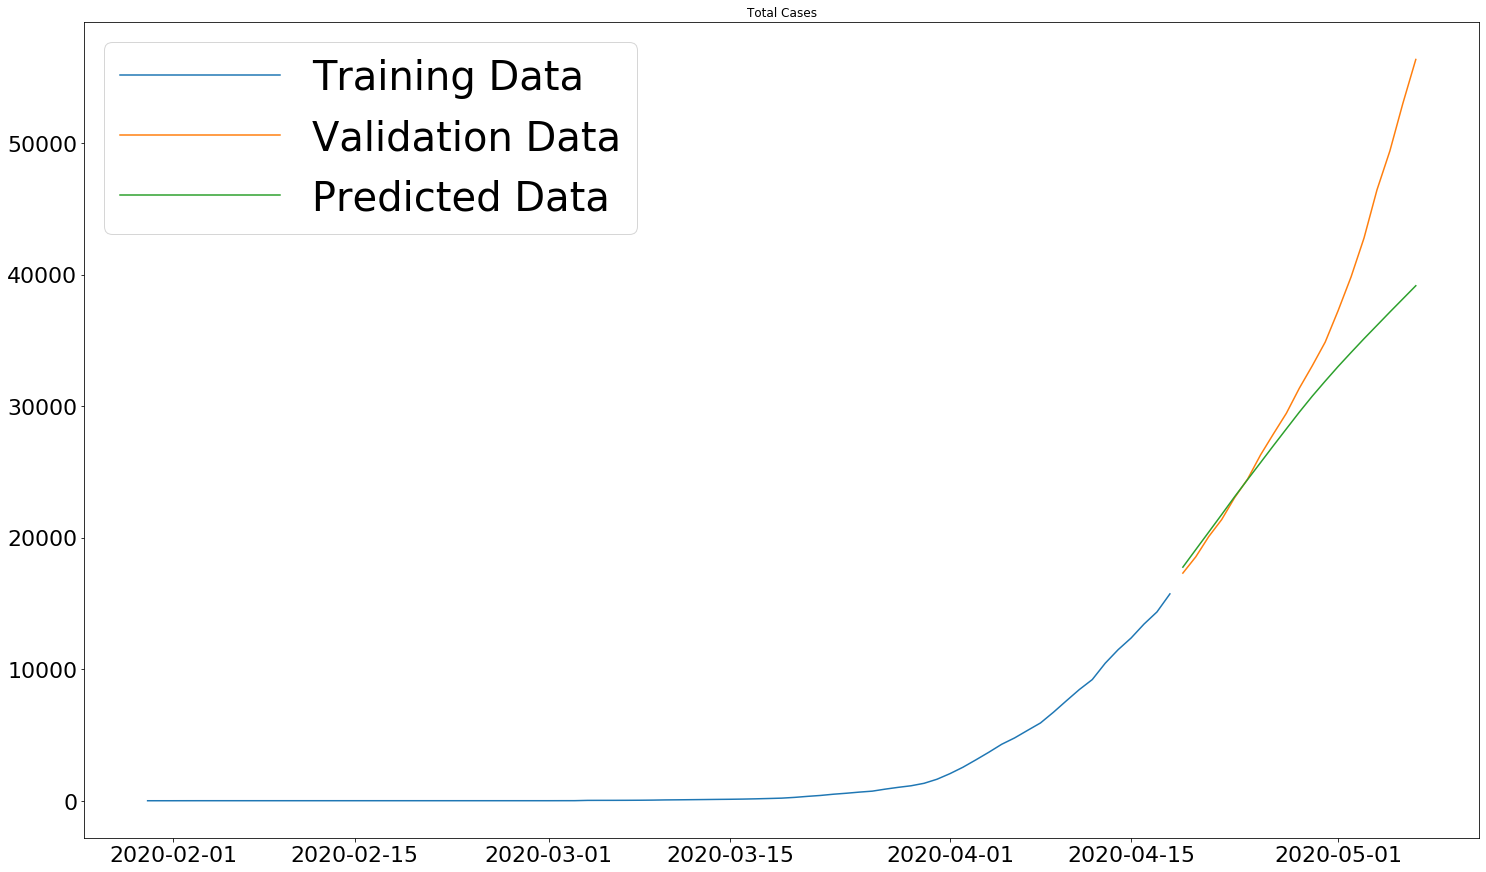

In [19]:
training = data[:80]
validation = data[80:]
validation['Predictions'] = predictions

rcParams['figure.figsize'] = 25,15
plt.title('Total Cases')
plt.plot(training['totalconfirmed'], label = "Training Data")
plt.plot(validation['totalconfirmed'], label = "Validation Data")
plt.plot(validation['Predictions'], label = "Predicted Data")
plt.legend()
plt.savefig('Predictions.png')
plt.show()

In [20]:
validation

,totalconfirmed,Predictions
Dates,,
2020-04-19,17305,17756.876953
2020-04-20,18544,19093.384766
2020-04-21,20081,20423.744141
2020-04-22,21373,21758.468750
2020-04-23,23040,23110.490234
2020-04-24,24448,24413.589844
2020-04-25,26283,25701.980469
2020-04-26,27890,26996.193359
2020-04-27,29458,28272.294922


In [21]:
res = model.evaluate(x_test, y_test)
metrics = model.metrics_names
print(str(metrics[0]) + ':' + str(res[0]))
print(str(metrics[1]) + ':' + str(res[1]))

19/19 [==============================] - 0s 15ms/step
loss:0.014968940988183022
rmse:0.1223476231098175


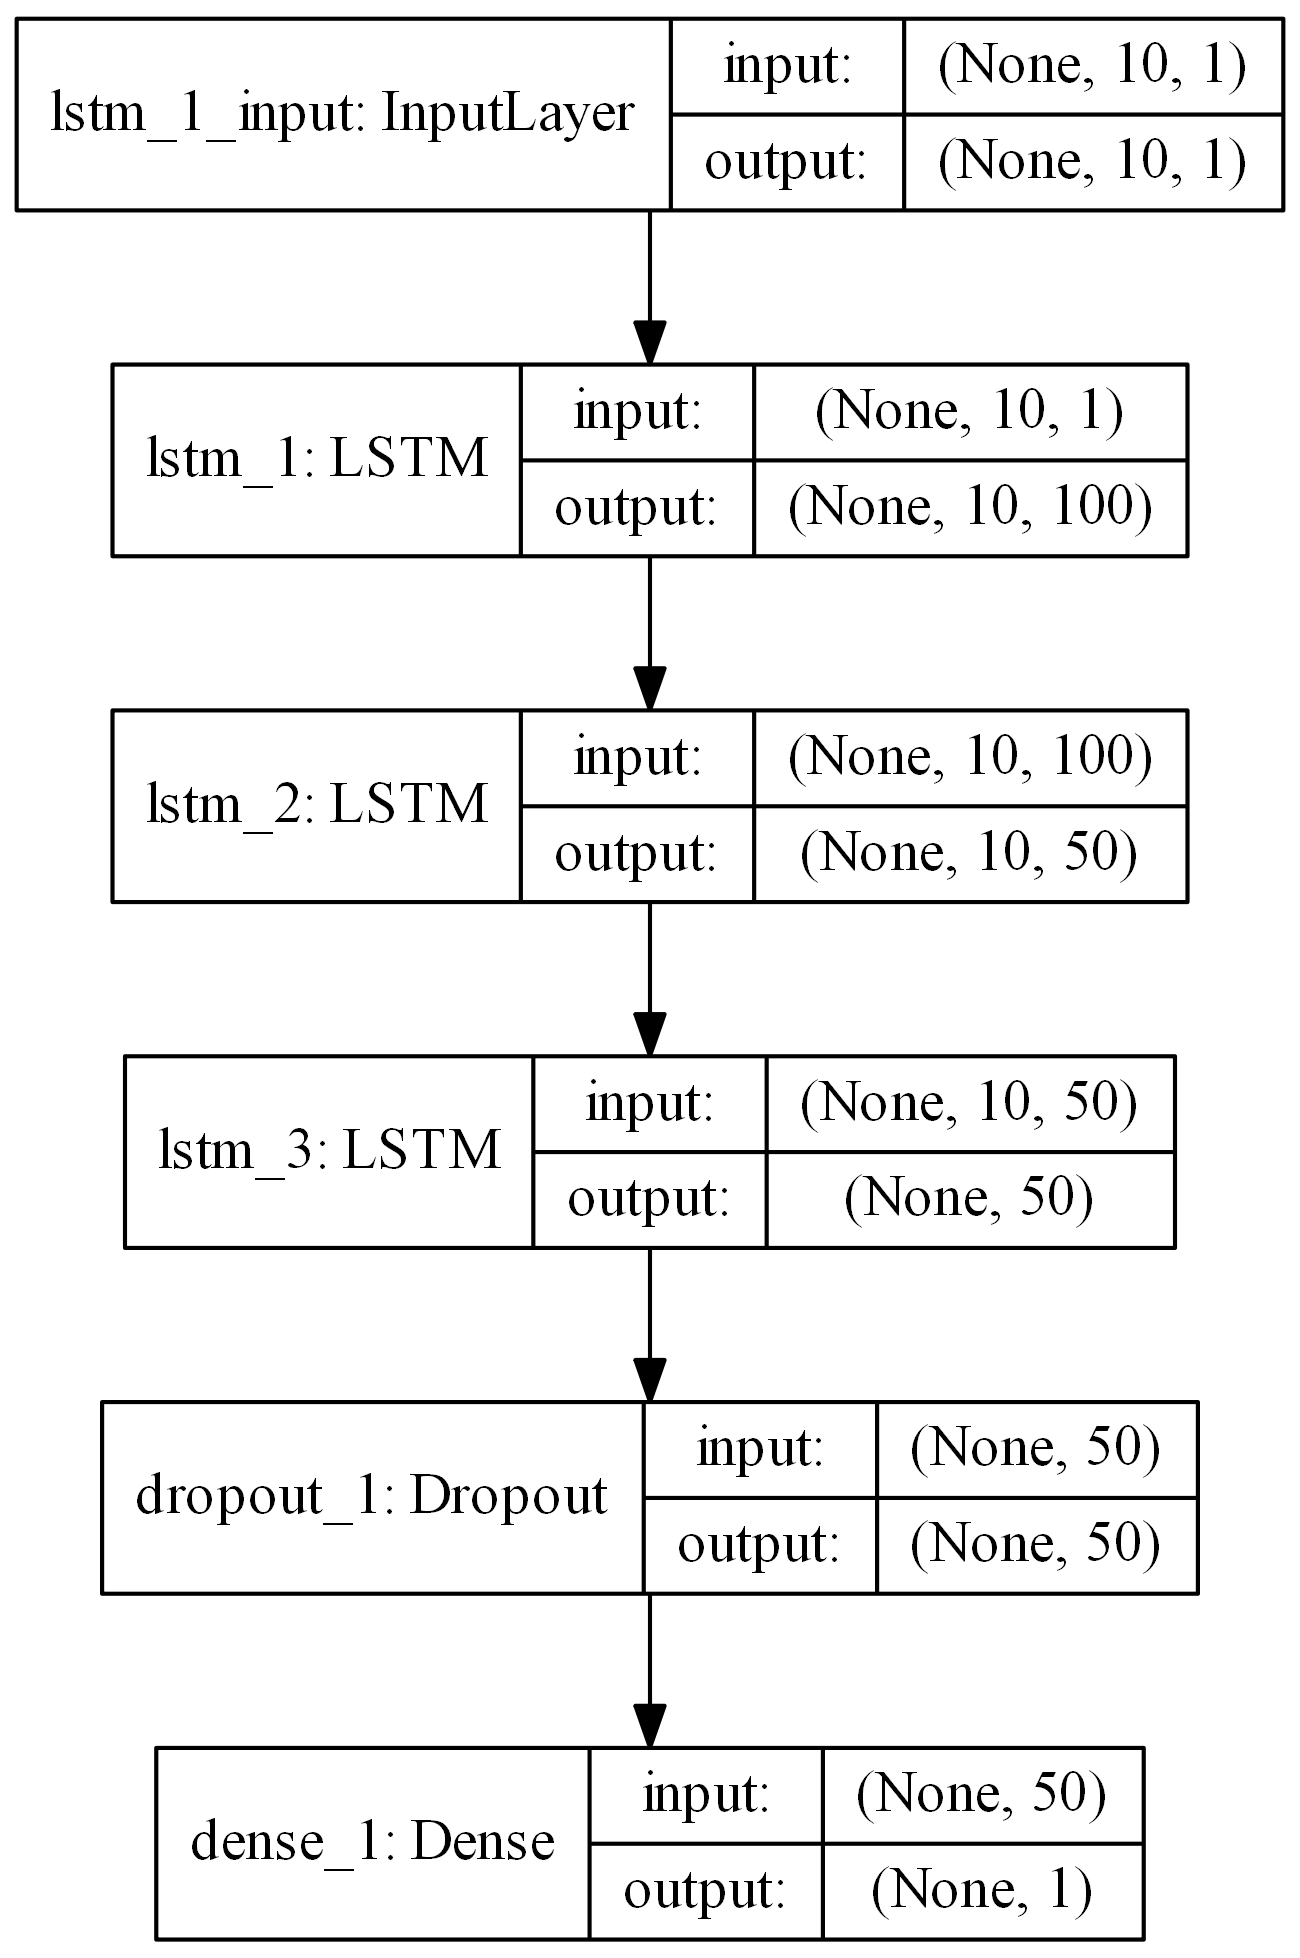

In [22]:
from keras.utils import plot_model
plot_model(model,show_shapes = True, dpi = 300, to_file='model.png')

In [23]:
tests = validation.values
actual = tests[:][0]
predicted = tests[:][1]

In [24]:
tests

array([[17305.        , 17756.87695312],
       [18544.        , 19093.38476562],
       [20081.        , 20423.74414062],
       [21373.        , 21758.46875   ],
       [23040.        , 23110.49023438],
       [24448.        , 24413.58984375],
       [26283.        , 25701.98046875],
       [27890.        , 26996.19335938],
       [29458.        , 28272.29492188],
       [31360.        , 29541.24414062],
       [33065.        , 30755.19335938],
       [34866.        , 31900.4375    ],
       [37262.        , 33014.01953125],
       [39826.        , 34078.10546875],
       [42778.        , 35124.56640625],
       [46434.        , 36137.8359375 ],
       [49405.        , 37153.5703125 ],
       [53007.        , 38151.18359375],
       [56351.        , 39150.0625    ]])